In [1]:
import pandas as pd
import os
from pathlib import Path

log_path = os.path.join(Path.cwd().parent, 'logs')
print(log_path)

independent_path = os.path.join(log_path, 'independent')
dependent_path = os.path.join(log_path, 'dependent')

print(independent_path)
print(dependent_path)

/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/logs
/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/logs/independent
/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/logs/dependent


In [2]:
# 2024-12-2 查看非跨被试2分类和4分类结果
binary_res = pd.read_excel(
    os.path.join(independent_path, "2024-11-28_22-55-40", "history_res.xlsx")
)
four_res = pd.read_excel(
    os.path.join(independent_path, "2024-11-28_23-22-25", "history_res.xlsx")
)

print(binary_res.iloc[31, :])
print(four_res.iloc[31, :])

# print(binary_res.iloc[:31, 2])
binary_std = binary_res.iloc[:31, 2].std()
four_std = four_res.iloc[:31, 2].std()
print(binary_std, four_std)


subject         Mean
epoch            NaN
acc         0.906254
loss        0.384739
f1-score    0.901943
cm               NaN
Name: 31, dtype: object
subject         Mean
epoch            NaN
acc         0.558468
loss         1.10841
f1-score    0.518974
cm               NaN
Name: 31, dtype: object
0.08941090511312688 0.07538852967270726


In [3]:
# 2024-12-2 查看跨被试2分类和4分类结果
binary_res = pd.read_excel(
    os.path.join(dependent_path, "2024-11-28_22-56-39", "history_res.xlsx")
)
four_res = pd.read_excel(
    os.path.join(dependent_path, "2024-11-28_23-23-00", "history_res.xlsx")
)

print(binary_res.iloc[10, :])
print(four_res.iloc[10, :])

# print(binary_res.iloc[:10, 2])

binary_std = binary_res.iloc[:10, 2].std()
four_std = four_res.iloc[:10, 2].std()
print(binary_std, four_std)


subject         Mean
epoch            NaN
acc         0.826091
loss         0.46691
f1-score    0.823948
cm               NaN
Name: 10, dtype: object
subject         Mean
epoch            NaN
acc         0.478492
loss        1.227913
f1-score    0.460451
cm               NaN
Name: 10, dtype: object
0.027633928518982713 0.02616577253633707


In [4]:
print(binary_res.iloc[-2,2])
(sum([(i[2] - binary_res.iloc[-2,2]) ** 2 for i in binary_res.iloc[:10, :].values]) / len(binary_res.iloc[:10, :])) ** 0.5

0.8260905760905759


0.02621584644548067

In [5]:
import re
import numpy as np
# 定义一个函数用于解析混淆矩阵字符串并转换为二维数组（numpy数组形式方便后续计算）
def parse_cm(cm_str):
    sub_lists_str = re.sub(r'^\[|\]$', '', cm_str).split('],[')
    cm = np.array([list(map(int, re.findall(r'\d+', sub_list_str))) for sub_list_str in sub_lists_str])
    return cm
test_df = binary_res.copy()
cm = test_df["cm"]
cm.dropna(inplace=True)

# 对DataFrame中的每一个混淆矩阵字符串应用解析函数，得到包含二维数组的新列
cm['cm_parsed'] = cm.apply(parse_cm)

print(cm['cm_parsed'])
# 将解析后的二维数组堆叠起来，方便计算每列平均值
stacked_cm = np.sum(cm['cm_parsed'].values, axis=0)

print(stacked_cm)
# 计算平均混淆矩阵（按列求平均）
avg_cm = np.sum(stacked_cm,axis=0).astype(int)

print(avg_cm)

cm_str = np.array2string(stacked_cm, separator=",")
print(cm_str)
print(type(cm_str))

0    [[51, 3], [12, 12]]
1     [[42, 8], [6, 22]]
2    [[44, 12], [5, 17]]
3     [[52, 7], [7, 12]]
4     [[47, 8], [4, 19]]
5    [[55, 3], [10, 10]]
6      [[57, 4], [7, 9]]
7    [[42, 6], [10, 19]]
8     [[37, 8], [2, 30]]
9     [[40, 9], [4, 24]]
Name: cm, dtype: object
[[467  68]
 [ 67 174]]
[534 242]
[[467, 68],
 [ 67,174]]
<class 'str'>


In [6]:

test_df = test_df.drop(columns=["epoch", "loss", "cm"])
test_df = test_df.set_index("subject")
test_df = test_df.T
# test_df.reset_index(inplace=True)

# 两行分别为acc和f1，将两行结果归并到一行，以/分割
test_df = test_df.apply(lambda x: x.apply(lambda x: "{:.2f}".format(x)))
print(test_df.index)
print(test_df.columns)

# 合并两行数据
combined_row = test_df.loc['acc'].astype(str) + '/' + test_df.loc['f1-score'].astype(str)
# 创建新的 DataFrame，更新 index 为 'acc/f1-score'
new_df = pd.DataFrame([combined_row], index=['acc/f1-score'])
new_df.head()


Index(['acc', 'f1-score'], dtype='object')
Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'Mean', 'Std'], dtype='object', name='subject')


subject,0,1,2,3,4,5,6,7,8,9,Mean,Std
acc/f1-score,0.81/0.79,0.82/0.82,0.78/0.79,0.82/0.82,0.85/0.85,0.83/0.82,0.86/0.85,0.79/0.79,0.87/0.87,0.83/0.83,0.83/0.82,0.00/0.00


In [8]:
# yaml文件
import os
import sys
import yaml
from pathlib import Path
import pandas as pd
def add_project_root_to_sys_path():
    """动态添加项目根目录到 sys.path"""
    project_root = Path.cwd().resolve().parent
    print(project_root)
    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

add_project_root_to_sys_path()

from argparse import ArgumentParser
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

from pathlib import Path
from common.utils import (
    load_config,
    seed_all,
    normalize_cm,
)  # 假设有一个工具函数来加载配置文件
from main import parse_args, modify_config

config_path = f"{Path.cwd().parent}/config/config.yaml"
config = load_config(config_path)
args = parse_args(args=[])
print(args)

config = modify_config(config, args)
print(config)


/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition
Namespace(checkpoint=None, config='/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/config/config.yaml', data='Ruiwen', dependent=None, infer_input=None, mode='train', model='MFAFESM', num_classes=None, resume=False, using_modality=None)
[960, 41, 119]
['eeg', 'eye', 'au']
{'model': {'feature_extract': {'input_dim': 75, 'hidden_dim': 160, 'tok': 0.5}, 'feature_align': {'input_size': [960, 41, 119], 'embed_dim': 160, 'seq_len': 10}, 'fusion': {'embed_dim': 160, 'num_heads': 8, 'd_model': 640}, 'attention_encoder': {'num_layers': 6, 'd_model': 640, 'num_heads': 8, 'd_ff': 2048, 'dropout': 0.1, 'embed_dim': 160}, 'classifier': {'nb_classes': 4, 'embed_dim': 1600}}, 'training': {'ex_name': 'First Fire', 'batch_size': 64, 'epochs': 5, 'learning_rate': 0.0001, 'weight_decay': 0.002, 'optimizer': 'adam', 'loss_function': 'cross_entropy', 'dependent': False, 'n_folds': 10}, 'data': {'data_path': '/data

In [9]:
# {'model': {'feature_extract': {'input_dim': 75, 'hidden_dim': 160, 'tok': 0.5}, 'feature_align': {'input_size': [960, 41, 119], 'embed_dim': 160, 'seq_len': 10}, 'fusion': {'embed_dim': 160, 'num_heads': 8, 'd_model': 160}, 'attention_encoder': {'num_layers': 6, 'd_model': 160, 'num_heads': 8, 'd_ff': 2048, 'dropout': 0.1, 'embed_dim': 160}, 'classifier': {'nb_classes': 4, 'embed_dim': 1600}}, 'training': {'ex_name': 'First Fire', 'batch_size': 64, 'epochs': 300, 'learning_rate': 0.0001, 'weight_decay': 0.002, 'optimizer': 'adam', 'loss_function': 'cross_entropy', 'dependent': False, 'n_folds': 10}, 'data': {'data_path': '/data/Ruiwen/data_with_ICA.pkl', 'subject_lists': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34], 'modalities': ['eeg', 'eye', 'au'], 'input_size': [960, 41, 119], 'num_workers': 4, 'ch_nums': 31, 'ex_nums': 48}, 'logging': {'log_dir': '/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/logs/independent', 'model_dir': '/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/outputs/independent', 'save_best_only': True}, 'device': {'gpu': True, 'gpu_ids': [0]}, 'seed': 42, 'num_classes': 4}

# 递归方式拆解字典，将嵌套字典的key拼接起来形成单个key
def dict_format(dic, parent_key=""):
    """
    递归方式拆解字典，将嵌套字典的key拼接起来形成单个key
    """
    items = []
    for k, v in dic.items():
        new_key = f"{parent_key}.{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(dict_format(v, new_key).items())
        elif isinstance(v, list):
            items.append((new_key, ",".join([str(i) for i in v])))
        else:
            items.append((new_key, v))
    return dict(items)

new_config = dict_format(config)
print(new_config)

{'model.feature_extract.input_dim': 75, 'model.feature_extract.hidden_dim': 160, 'model.feature_extract.tok': 0.5, 'model.feature_align.input_size': '960,41,119', 'model.feature_align.embed_dim': 160, 'model.feature_align.seq_len': 10, 'model.fusion.embed_dim': 160, 'model.fusion.num_heads': 8, 'model.fusion.d_model': 640, 'model.attention_encoder.num_layers': 6, 'model.attention_encoder.d_model': 640, 'model.attention_encoder.num_heads': 8, 'model.attention_encoder.d_ff': 2048, 'model.attention_encoder.dropout': 0.1, 'model.attention_encoder.embed_dim': 160, 'model.classifier.nb_classes': 4, 'model.classifier.embed_dim': 1600, 'training.ex_name': 'First Fire', 'training.batch_size': 64, 'training.epochs': 5, 'training.learning_rate': 0.0001, 'training.weight_decay': 0.002, 'training.optimizer': 'adam', 'training.loss_function': 'cross_entropy', 'training.dependent': False, 'training.n_folds': 10, 'data.data_path': '/data/Ruiwen/data_with_ICA.pkl', 'data.subject_lists': '2,3,4,5,6,7,8,

In [10]:
config_df = pd.DataFrame(new_config, index=[0])
config_df.head()

,model.feature_extract.input_dim,model.feature_extract.hidden_dim,model.feature_extract.tok,model.feature_align.input_size,model.feature_align.embed_dim,model.feature_align.seq_len,model.fusion.embed_dim,model.fusion.num_heads,model.fusion.d_model,model.attention_encoder.num_layers,...,data.num_workers,data.ch_nums,data.ex_nums,logging.log_dir,logging.model_dir,logging.save_best_only,device.gpu,device.gpu_ids,seed,num_classes
0,75,160,0.5,"960,41,119",160,10,160,8,640,6,...,4,31,48,/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_...,/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_...,True,True,0,42,4


In [11]:
new_df.head()

subject,0,1,2,3,4,5,6,7,8,9,Mean,Std
acc/f1-score,0.81/0.79,0.82/0.82,0.78/0.79,0.82/0.82,0.85/0.85,0.83/0.82,0.86/0.85,0.79/0.79,0.87/0.87,0.83/0.83,0.83/0.82,0.00/0.00


In [18]:
# 将两个 DataFrame 横向合并
new_df = new_df.reset_index(drop=True)
# 将cm放在最后一列
config_df["cm"] = cm_str

final_df = pd.concat([config_df, new_df], axis=1)
final_df.head()

,model.feature_extract.input_dim,model.feature_extract.hidden_dim,model.feature_extract.tok,model.feature_align.input_size,model.feature_align.embed_dim,model.feature_align.seq_len,model.fusion.embed_dim,model.fusion.num_heads,model.fusion.d_model,model.attention_encoder.num_layers,...,2,3,4,5,6,7,8,9,Mean,Std
0,75,160,0.5,"960,41,119",160,10,160,8,640,6,...,0.78/0.79,0.82/0.82,0.85/0.85,0.83/0.82,0.86/0.85,0.79/0.79,0.87/0.87,0.83/0.83,0.83/0.82,0.00/0.00


# 可视化结果

## HCI库

In [1]:
import os
import sys
import yaml
from pathlib import Path
import pandas as pd
import numpy as np
import ast

def add_project_root_to_sys_path():
    """动态添加项目根目录到 sys.path"""
    project_root = Path.cwd().resolve().parent
    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

add_project_root_to_sys_path()
from notebooks.plot_res import plot_hci_acc, plot_exp_cm

In [4]:
path = "/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/logs/independent/HCI/history_HCI_24_3.csv"
df = pd.read_csv(path)
save_path = "/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/outputs/imgs/HCI/independent"
for i, row in df.iterrows():
    date = row["timestamp"]
    num_classes = row["model.classifier.nb_classes"]
    label_type = row["data.label_type"]
    # label_type首字母大写
    label_type = label_type.capitalize()

    begin_title = f"HCI Independent {label_type}"
    print(begin_title)
    plot_hci_acc(
        path,
        False,
        date,
        num_classes,
        label_type,
        save_path,
        save_type="svg",
        show=False,
    )
    plot_exp_cm(
        path, date, num_classes, begin_title, save_path, save_type="svg", show=False
    )

HCI Independent Arousal
HCI_Independent_Arousal_Confusion_Matrix_3-classification.svg


/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


HCI Independent Valence
HCI_Independent_Valence_Confusion_Matrix_3-classification.svg


/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


<Figure size 50000x50000 with 0 Axes>

<Figure size 50000x50000 with 0 Axes>

In [ ]:
# dependent


## Raven

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path


path = "/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/logs/independent/Ruiwen/history_Ruiwen_31_0.csv"

In [2]:
df = pd.read_csv(path)
df.head()

,timestamp,model.type,model.missing,model.feature_extract.input_dim,model.feature_extract.hidden_dim,model.feature_extract.tok,model.feature_align.input_size,model.feature_align.embed_dim,model.feature_align.seq_len,model.fusion.embed_dim,...,24,25,26,27,28,29,30,Acc/Std,F1/Std,cm
0,2024-12-12_23-49-21,iterative_fusion,False,75,160,0.5,"960,41,119",160,10,160,...,0.9615/0.9555,0.8889/0.8889,1.0000/1.0000,0.7407/0.7407,0.8400/0.8470,0.9655/0.9634,0.9167/0.9132,0.9206/0.0773,0.9190/0.0761,"[[504, 31, 29,212]]"
1,2024-12-12_23-49-26,iterative_fusion,False,75,160,0.5,"960,41,119",160,10,160,...,0.5417/0.4318,0.5625/0.5416,0.7292/0.7112,0.5000/0.3877,0.5625/0.5517,0.6042/0.6098,0.5208/0.4692,0.5833/0.0650,0.5490/0.0761,"[[347, 23, 47,118, 53, 51, 57, 36, 27, 24,153,..."


In [3]:
# 找到日期为2024-12-12_23-49-21所在的行
df[df["timestamp"] == "2024-12-12_23-49-21"]

,timestamp,model.type,model.missing,model.feature_extract.input_dim,model.feature_extract.hidden_dim,model.feature_extract.tok,model.feature_align.input_size,model.feature_align.embed_dim,model.feature_align.seq_len,model.fusion.embed_dim,...,24,25,26,27,28,29,30,Acc/Std,F1/Std,cm
0,2024-12-12_23-49-21,iterative_fusion,False,75,160,0.5,"960,41,119",160,10,160,...,0.9615/0.9555,0.8889/0.8889,1.0000/1.0000,0.7407/0.7407,0.8400/0.8470,0.9655/0.9634,0.9167/0.9132,0.9206/0.0773,0.9190/0.0761,"[[504, 31, 29,212]]"


In [ ]:
# 获取后34列的值
new_df = df.iloc[:, -34:]
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,Acc/Std,F1/Std,cm
0,0.9231/0.9152,1.0000/1.0000,0.9697/0.9548,0.8947/0.8929,0.9583/0.9597,0.9667/0.9646,0.8571/0.8571,0.9091/0.9115,0.8400/0.8322,0.9333/0.9333,...,0.9615/0.9555,0.8889/0.8889,1.0000/1.0000,0.7407/0.7407,0.8400/0.8470,0.9655/0.9634,0.9167/0.9132,0.9206/0.0773,0.9190/0.0761,"[[504, 31, 29,212]]"
1,0.5625/0.5498,0.6042/0.5094,0.6458/0.5749,0.5000/0.4945,0.5208/0.4715,0.6042/0.5764,0.5208/0.5347,0.5417/0.5019,0.5208/0.4855,0.6042/0.5874,...,0.5417/0.4318,0.5625/0.5416,0.7292/0.7112,0.5000/0.3877,0.5625/0.5517,0.6042/0.6098,0.5208/0.4692,0.5833/0.0650,0.5490/0.0761,"[[347, 23, 47,118, 53, 51, 57, 36, 27, 24,153,..."


In [7]:
acc = []
f1 = []
for i in range(31):
    acc_, f1_ = map(float, new_df.iloc[0, i].split("/"))
    acc.append(acc_)
    f1.append(f1_)
acc.append(np.mean(acc))
f1.append(np.mean(f1))
print(acc)
print(f1)

[0.9231, 1.0, 0.9697, 0.8947, 0.9583, 0.9667, 0.8571, 0.9091, 0.84, 0.9333, 0.9333, 1.0, 0.8696, 0.84, 1.0, 0.6667, 0.92, 1.0, 1.0, 0.875, 0.95, 0.9655, 0.9545, 1.0, 0.9615, 0.8889, 1.0, 0.7407, 0.84, 0.9655, 0.9167, 0.920641935483871]
[0.9152, 1.0, 0.9548, 0.8929, 0.9597, 0.9646, 0.8571, 0.9115, 0.8322, 0.9333, 0.9307, 1.0, 0.8726, 0.8453, 1.0, 0.6697, 0.914, 1.0, 1.0, 0.8729, 0.9499, 0.9486, 0.9553, 1.0, 0.9555, 0.8889, 1.0, 0.7407, 0.847, 0.9634, 0.9132, 0.919]


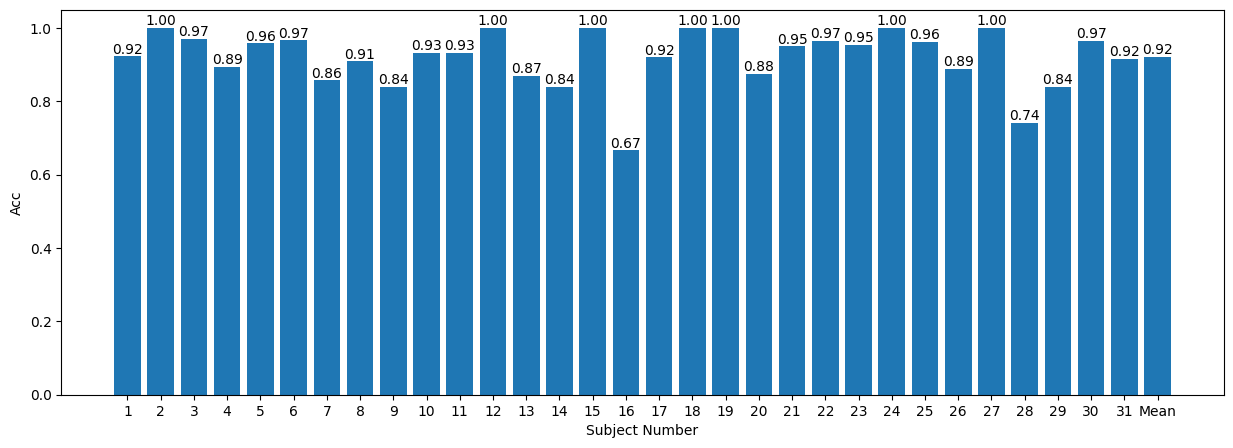

In [8]:
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(acc)), acc)
# plt.title("four classification")
x_label = "Subject Number"
plt.xlabel(x_label)
plt.ylabel("Acc")
plt.xticks(
    np.arange(len(acc)),
    list(np.arange(len(acc) - 1) + 1) + ["Mean"],
)
for i, a in enumerate(acc):
    plt.text(i, a, "%.2f" % a, ha="center", va="bottom", fontsize=10)

plt.show()
plt.close()

In [9]:
# 处理混淆矩阵
import ast
cm = new_df.iloc[0, -1]
cm = ast.literal_eval(cm)
cm = np.array(cm)
print(cm)
print(cm.shape)
print(type(cm))
print(cm.dtype)
cm = cm.reshape(2,2)
print(cm)



[[504  31  29 212]]
(1, 4)
<class 'numpy.ndarray'>
int64
[[504  31]
 [ 29 212]]


/tmp/ipykernel_1136680/3249555341.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


<Figure size 50000x50000 with 0 Axes>

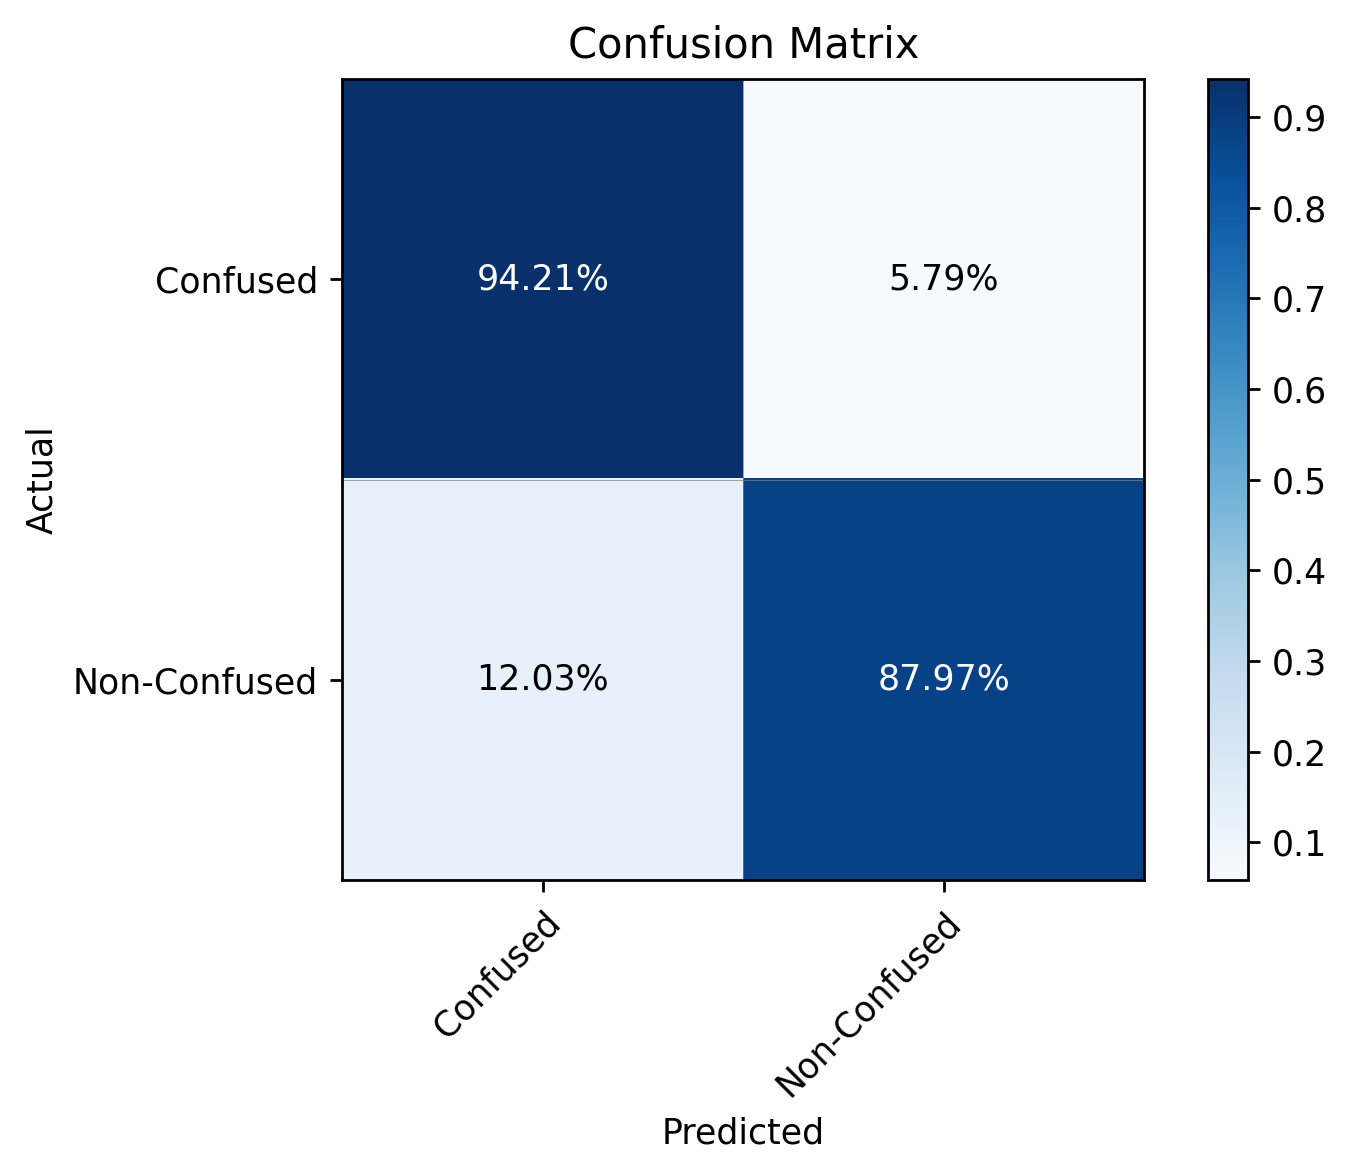

In [42]:
classes = ["Confused","Non-Confused"]
title = "Confusion Matrix"
cmap = plt.cm.Blues

plt.rc("font", family="sans-serif", size=10)  # set font
plt.rcParams["font.sans-serif"] = [
    "Tahoma",
    "DejaVu Sans",
    "SimHei",
    "Lucida Grande",
    "Verdana",
]  # to display Chinese
plt.rcParams["axes.unicode_minus"] = False  #  to display negative  sign
plt.figure(figsize=(200, 200))
plt.rcParams["figure.dpi"] = 250  # dpi

# Normalize
# cm = cm.numpy()
# cm = cm.T
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Cells that account for less than 1%, set to 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if int(cm[i, j] * 100 + 0.5) == 0:
            cm[i, j] = 0

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# color bar
tick_marks = np.arange(len(classes))

ax.set(
    xticklabels=list(range(len(classes))),
    yticklabels=list(range(len(classes))),
    title=title,
    ylabel="Actual",
    xlabel="Predicted",
)
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# drawing  grid
ax.set_xticks(np.arange(cm.shape[1] + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(cm.shape[0] + 1) - 0.5, minor=True)
ax.grid(which="minor", color="gray", linestyle="-", linewidth=0.2)
ax.tick_params(which="minor", bottom=False, left=False)

# Rotate the labels on the x-axis by 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Mark percentage information
fmt = "d"
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if int(cm[i, j] * 100 + 0.5) > 0:
            ax.text(
                j,
                i,
                "{:.2f}".format(cm[i, j] * 100, fmt) + "%",
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
fig.tight_layout()

In [10]:
def plot_raven_cm(path, date, num_classes, save_path=None, save_type="png", show=False):
    df = pd.read_csv(path)
    cm = df[df["timestamp"] == date].iloc[:, -1].values[0]
    cm = ast.literal_eval(cm)
    cm = np.array(cm)
    cm = cm.reshape(num_classes, num_classes)
    if num_classes == 2:
        classes = ["Confused", "Non-Confused"]
    else:
        classes = ["Confused", "Guess", "Non-Confused", "Think-right"]
    title = "Confusion Matrix"
    cmap = plt.cm.Blues
    
    plt.rc("font", family="sans-serif", size=10)  # set font
    plt.rcParams["font.sans-serif"] = [
        "Tahoma",
        "DejaVu Sans",
        "SimHei",
        "Lucida Grande",
        "Verdana",
    ]  # to display Chinese
    plt.rcParams["axes.unicode_minus"] = False  #  to display negative  sign
    plt.figure(figsize=(200, 200))
    plt.rcParams["figure.dpi"] = 250  # dpi

    # Normalize
    # cm = cm.numpy()
    # cm = cm.T
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # Cells that account for less than 1%, set to 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if int(cm[i, j] * 100 + 0.5) == 0:
                cm[i, j] = 0

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # color bar
    tick_marks = np.arange(len(classes))

    ax.set(
        xticklabels=list(range(len(classes))),
        yticklabels=list(range(len(classes))),
        title=title,
        ylabel="Actual",
        xlabel="Predicted",
    )
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # drawing  grid
    ax.set_xticks(np.arange(cm.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(cm.shape[0] + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle="-", linewidth=0.2)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Rotate the labels on the x-axis by 45 degrees
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Mark percentage information
    fmt = "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if int(cm[i, j] * 100 + 0.5) > 0:
                ax.text(
                    j,
                    i,
                    "{:.2f}".format(cm[i, j] * 100, fmt) + "%",
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black",
                )
    fig.tight_layout()

    file_name = f"Ruiwen_{num_classes}_cm.{save_type}"
    if save_path:
        plt.savefig(save_path, format=save_type)
    if show:
        plt.show()
    plt.close()

/tmp/ipykernel_1136680/1501367689.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


<Figure size 50000x50000 with 0 Axes>

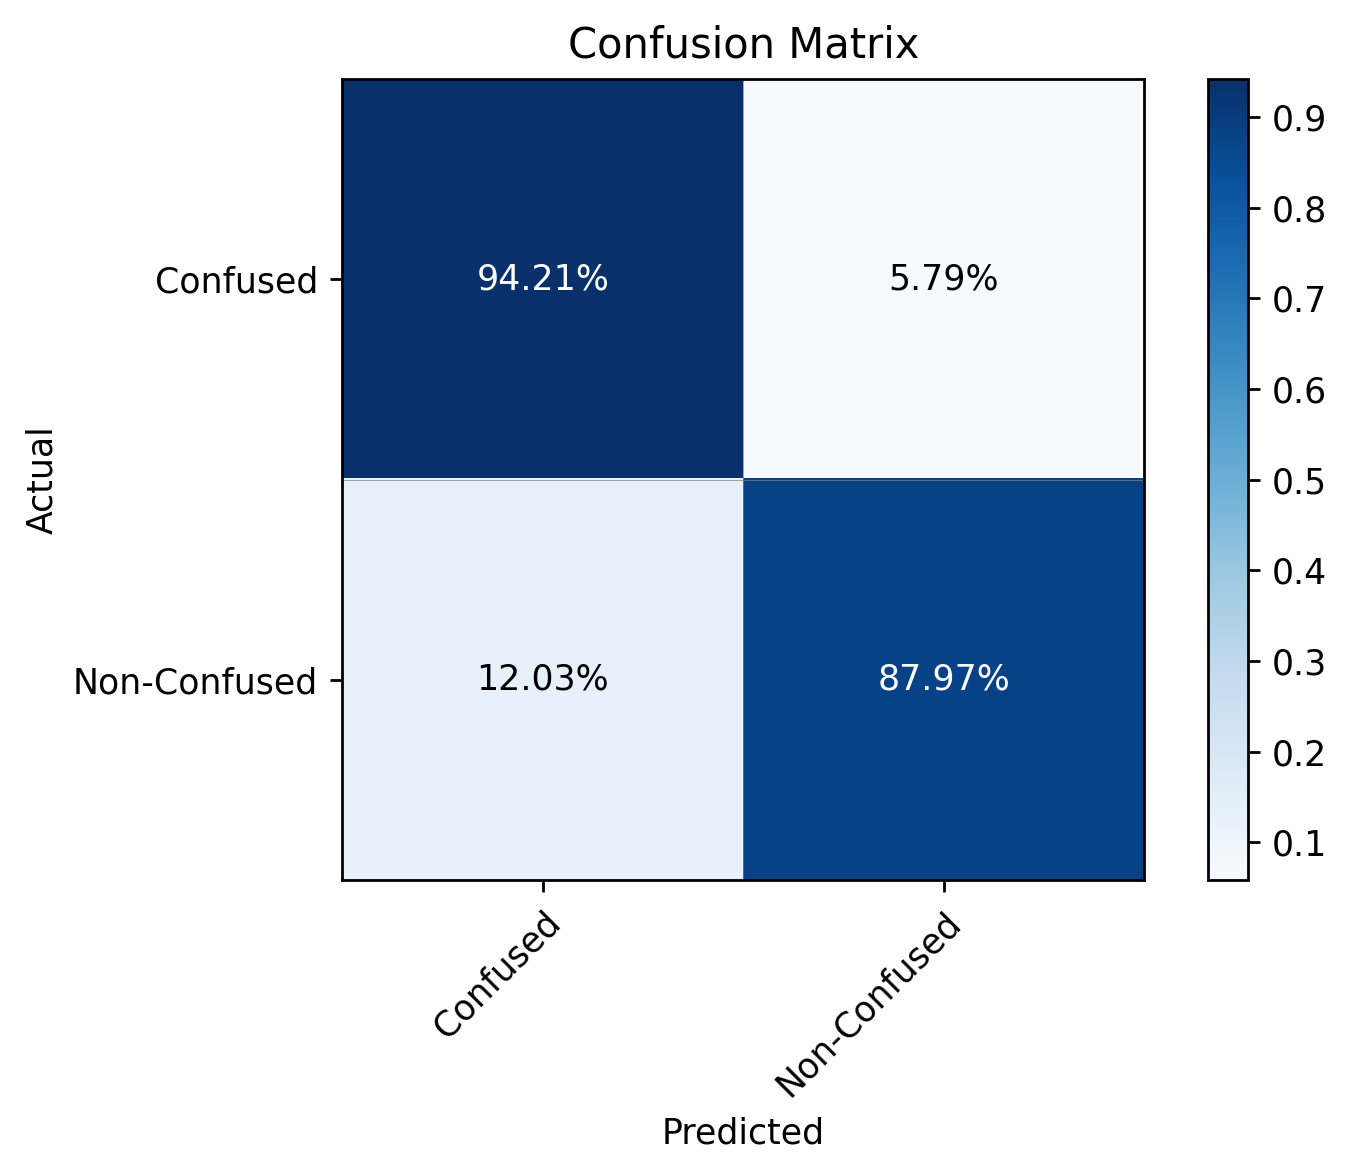

In [47]:
plot_raven_cm(path, "2024-12-12_23-49-21", 2, save_path=None, save_type="png", show=True)

In [20]:
def plot_raven_acc(path, dependent, date, num_classes):
    df = pd.read_csv(path)
    if dependent:
        num_persons = 10
        figsize = (int(num_persons / 2 * 1.5), 5)
    else:
        num_persons = 30
        figsize = (15, 5)

    df = df[df["timestamp"] == date].iloc[:, -(num_persons + 3) :]
    acc = []
    f1 = []
    for i in range(num_persons):
        acc_, f1_ = map(float, df.iloc[0, i].split("/"))
        acc.append(acc_)
        f1.append(f1_)
    acc.append(np.mean(acc))
    f1.append(np.mean(f1))
    plt.figure(figsize=figsize)
    plt.bar(np.arange(len(acc)), acc)
    if dependent:
        x_label = "Fold Number"
    else:
        x_label = "Subject Number"
    plt.xlabel(x_label)
    plt.ylabel("Acc")
    plt.xticks(
        np.arange(len(acc)),
        list(np.arange(len(acc) - 1) + 1) + ["Mean"],
    )
    for i, a in enumerate(acc):
        plt.text(i, a, "%.2f" % a, ha="center", va="bottom", fontsize=10)
    plt.title(
        f"Ruiwen {'Dependent' if dependent else 'Independent'} {num_classes}-classification Acc"
    )
    plt.show()

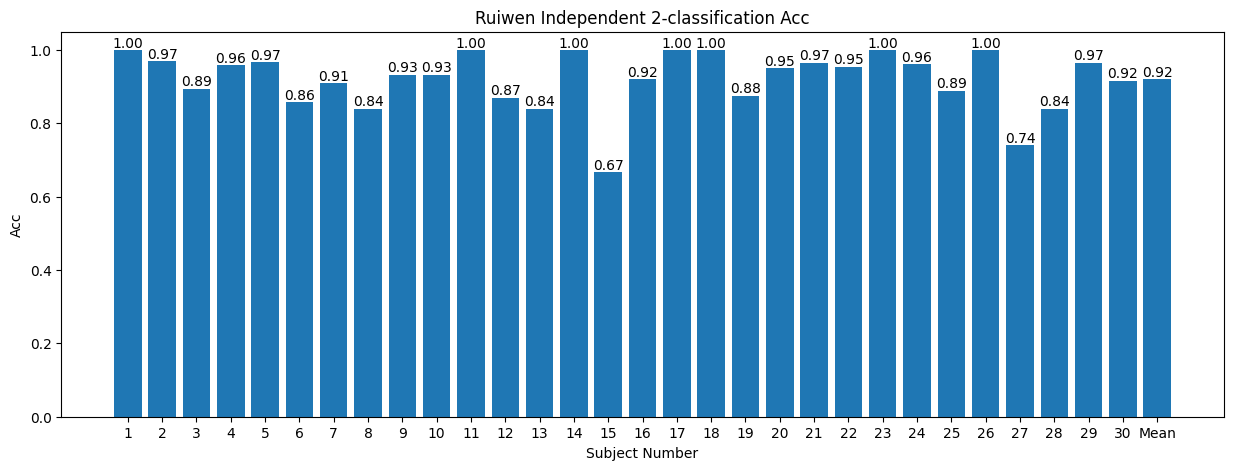

In [21]:
plot_raven_acc(path, dependent=False, date="2024-12-12_23-49-21", num_classes=2)

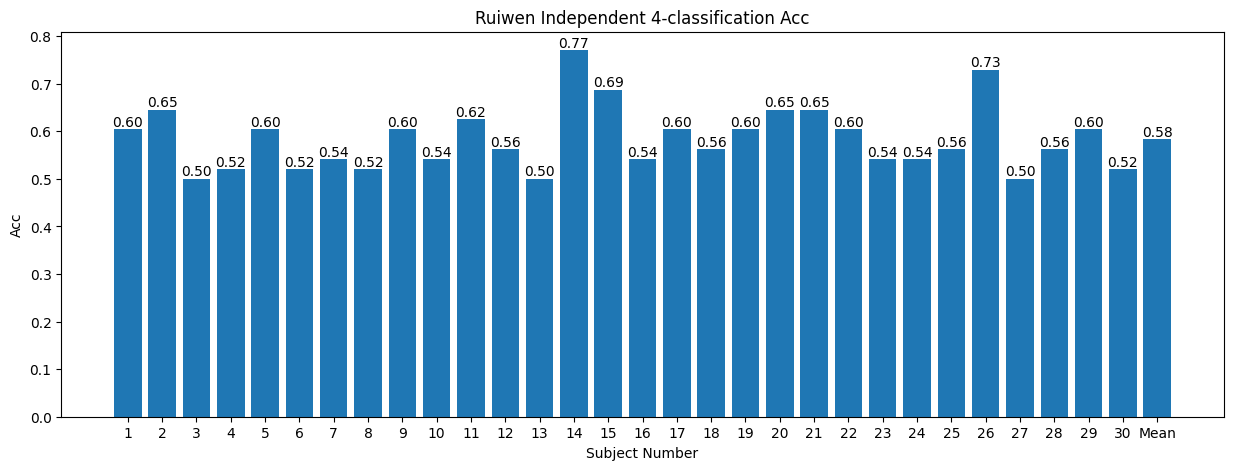

In [22]:
plot_raven_acc(path, dependent=False, date="2024-12-12_23-49-26", num_classes=4)

### 正式对Raven结果一个图的绘制和保存，用于论文中

In [1]:
import os
import sys
import yaml
from pathlib import Path
import pandas as pd
import numpy as np
import ast

def add_project_root_to_sys_path():
    """动态添加项目根目录到 sys.path"""
    project_root = Path.cwd().resolve().parent
    print(project_root)
    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

add_project_root_to_sys_path()

from notebooks.plot_res import plot_cm, plot_exp_cm, plot_raven_acc

/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition


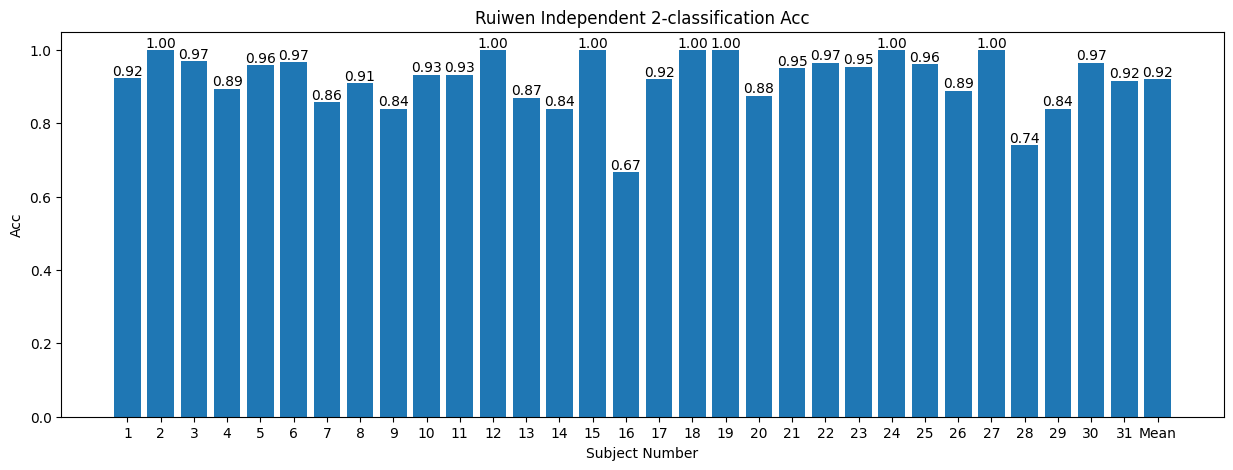

In [ ]:
path = "/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/logs/independent/Ruiwen/history_Ruiwen_31_0.csv"
date = "2024-12-12_23-49-21"
num_classes = 2
save_path = (
    "/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/outputs/imgs"
)
begin_title = "Ruiwen EEG Eye AU Independent"
plot_raven_acc(
    path,
    dependent=False,
    date=date,
    num_classes=num_classes,
    save_path=save_path,
    save_type="svg",
    show=True,
)
plot_exp_cm(
    path,
    date,
    num_classes,
    begin_title=begin_title,
    save_path=save_path,
    save_type="svg",
    show=True,
)

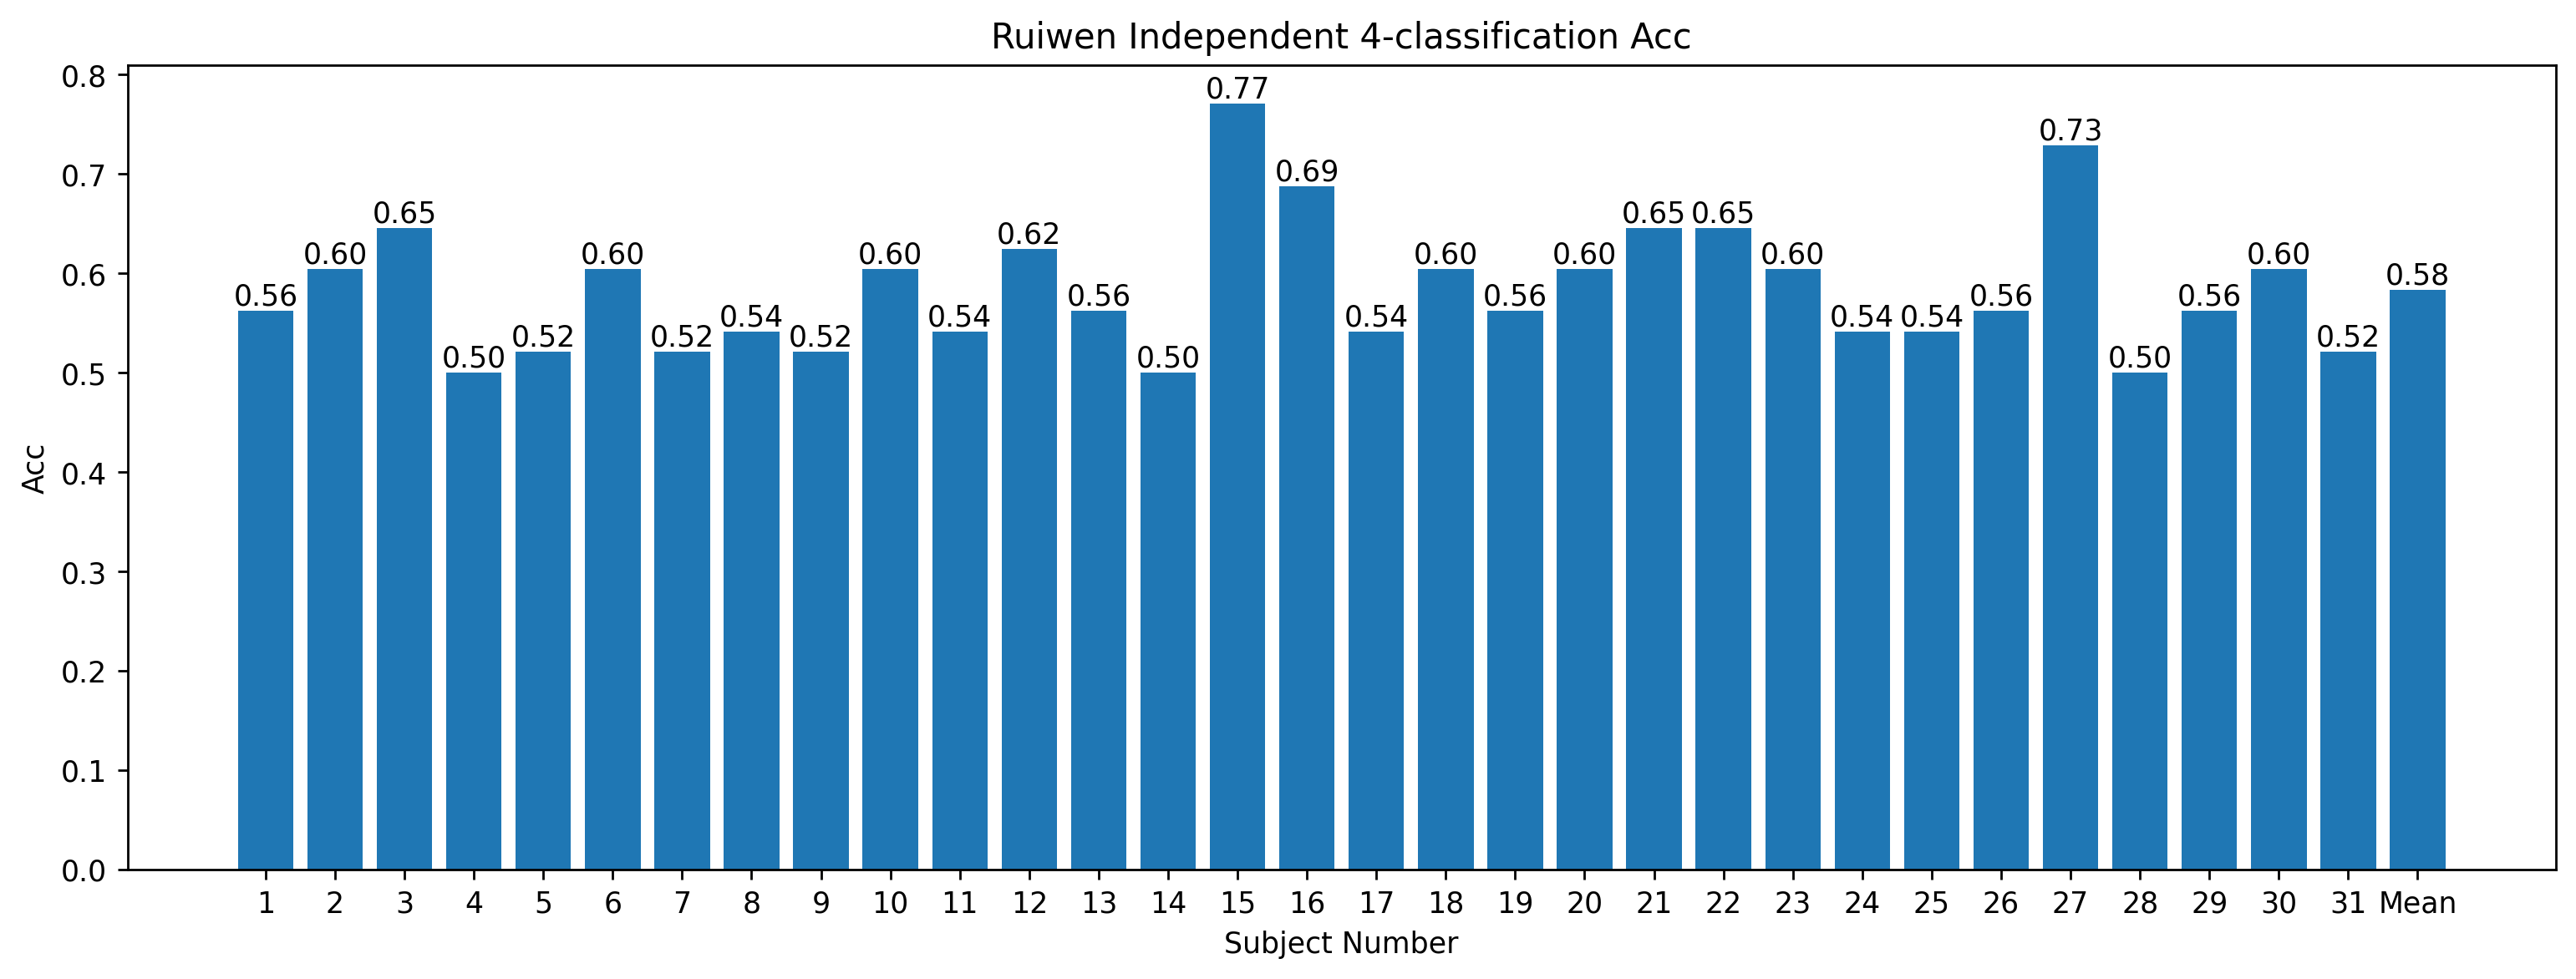

Ruiwen_EEG_Eye_AU_Independent_Confusion_Matrix_4-classification.svg


/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:166: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


<Figure size 50000x50000 with 0 Axes>

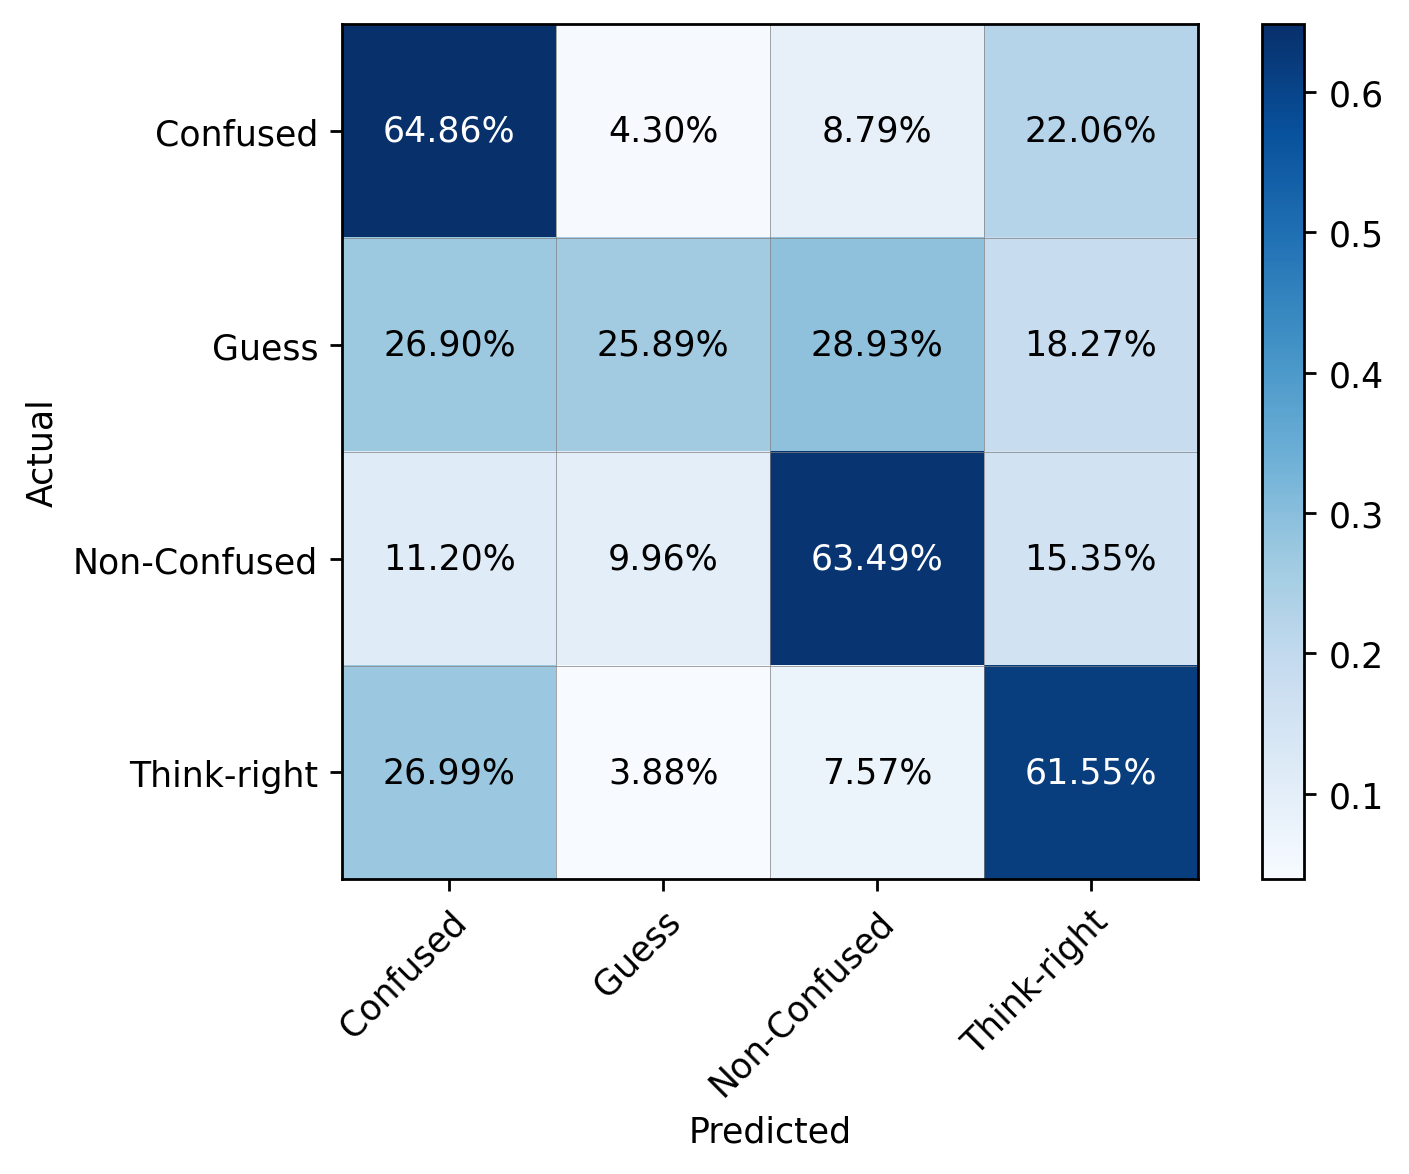

In [3]:
date = "2024-12-12_23-49-26"
num_classes = 4
save_path = (
    "/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/outputs/imgs"
)
begin_title = "Ruiwen EEG Eye AU Independent"
plot_raven_acc(
    path,
    dependent=False,
    date=date,
    num_classes=num_classes,
    save_path=save_path,
    save_type="svg",
    show=True,
)
plot_exp_cm(
    path,
    date,
    num_classes,
    begin_title=begin_title,
    save_path=save_path,
    save_type="svg",
    show=True,
)

#### 历史各个模态组合

In [13]:
path = "/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/logs/independent/history_Ruiwen_31_0.csv"
df = pd.read_csv(path)
save_path = "/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/outputs/imgs"
# 只取timestamp列和data.modalities、model.classifier.nb_classes列
df = df[["timestamp", "data.modalities", "model.classifier.nb_classes"]]
for i, row in df.iterrows():
    date = row["timestamp"]
    num_classes = row["model.classifier.nb_classes"]
    modalities = row["data.modalities"]
    begin_title = f"Ruiwen {modalities} Independent"
    if modalities == "eeg,eye,au":
        continue
    print(date, num_classes, modalities, begin_title)
    plot_exp_cm(
        path,
        date,
        num_classes,
        begin_title=begin_title,
        save_path=save_path,
        save_type="svg",
        show=False,
    )

2024-12-04_20-27-42_1 2 au Ruiwen au Independent
Ruiwen_au_Independent_Confusion_Matrix_2-classification.svg
2024-12-04_20-27-40 2 eye Ruiwen eye Independent


/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(
/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(
/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


Ruiwen_eye_Independent_Confusion_Matrix_2-classification.svg
2024-12-04_20-27-37 2 eye,au Ruiwen eye,au Independent
Ruiwen_eye,au_Independent_Confusion_Matrix_2-classification.svg
2024-12-04_20-27-42 4 eye Ruiwen eye Independent
Ruiwen_eye_Independent_Confusion_Matrix_4-classification.svg
2024-12-04_20-27-45 4 au Ruiwen au Independent


/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(
/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


Ruiwen_au_Independent_Confusion_Matrix_4-classification.svg
2024-12-04_20-27-34 2 eeg Ruiwen eeg Independent
Ruiwen_eeg_Independent_Confusion_Matrix_2-classification.svg


/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(
/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


2024-12-04_20-27-38 4 eye,au Ruiwen eye,au Independent
Ruiwen_eye,au_Independent_Confusion_Matrix_4-classification.svg
2024-12-04_20-27-31 2 eeg,au Ruiwen eeg,au Independent


/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(
/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


Ruiwen_eeg,au_Independent_Confusion_Matrix_2-classification.svg
2024-12-04_20-27-29 2 eeg,eye Ruiwen eeg,eye Independent
Ruiwen_eeg,eye_Independent_Confusion_Matrix_2-classification.svg
2024-12-04_20-27-35 4 eeg Ruiwen eeg Independent
Ruiwen_eeg_Independent_Confusion_Matrix_4-classification.svg
2024-12-04_20-27-32 4 eeg,au Ruiwen eeg,au Independent


/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(
/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


Ruiwen_eeg,au_Independent_Confusion_Matrix_4-classification.svg
2024-12-04_20-27-30 4 eeg,eye Ruiwen eeg,eye Independent


/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


Ruiwen_eeg,eye_Independent_Confusion_Matrix_4-classification.svg


: 

#### 非跨被试结果

In [5]:
path = "/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/logs/dependent/Ruiwen/history_Ruiwen_10_0.csv"
df = pd.read_csv(path)
save_path = "/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/outputs/imgs/dependent"
# 只取timestamp列和data.modalities、model.classifier.nb_classes列
df = df[["timestamp", "data.modalities", "model.classifier.nb_classes"]]
for i, row in df.iterrows():
    date = row["timestamp"]
    num_classes = row["model.classifier.nb_classes"]
    # modalities = row["data.modalities"]
    begin_title = f"Ruiwen Dependent"
    # if modalities == "eeg,eye,au":
        # continue
    # print(date, num_classes, modalities, begin_title)
    # plot_raven_acc(
    #     path,
    #     dependent=True,
    #     date=date,
    #     num_classes=num_classes,
    #     save_path=save_path,
    #     save_type="svg",
    #     show=True,
    # )
    plot_exp_cm(
        path,
        date,
        num_classes,
        begin_title=begin_title,
        save_path=save_path,
        save_type="svg",
        show=False,
    )

/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(
/mnt/nvme1/yihaoyuan/Raven/RavenEx/multimodal_emotion_recognition/notebooks/plot_res.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


Ruiwen_Dependent_Confusion_Matrix_2-classification.svg
Ruiwen_Dependent_Confusion_Matrix_4-classification.svg


<Figure size 50000x50000 with 0 Axes>

<Figure size 50000x50000 with 0 Axes>